# Notebook requirements
This notebook requires the following packages that are registered on `METADATA`, that is, you can install them by `Pkg.add`. The `Optim` package that is registered is quite old, and I suggest you to use the development version that can be installed by `Pkg.checkout("Optim")`. 

In [10]:
using DataFrames, Optim,  Plots

For the last part, I use I package I am writing called `MomentBasedEstimators`. This package is not yet registered on `METADATA` and you have to install it yourself. Here is what do you need to do 

In [ ]:
Pkg.clone("https://github.com/gragusa/Divergences.jl.git")
Pkg.clone("https://github.com/gragusa/MomentBasedEstimators.jl.git")

# Generalized method of moments (GMM)

Econometric models are often postulated in terms of moment restrictions:

$$
\int h(w,\theta_{0})F(dw)=0,\
$$

where $w\in\mathcal{W}\subseteq\mathbb{R}^{L}$ is a random vector
with unknown probability distribution $F$, and $h(w,\theta)$ is
an $M\times1$ vector of functions of $w$ and the parameter $\theta\in\Theta\subset\mathbb{R}^{K}$,
$h:\mathcal{W}\times\Theta\mapsto\mathbb{R}^{M}$. 

Given a random sample from $w$, $(w_{1},\ldots,w_{T})$, the objective is to estimate
$\theta_{0}$. Simultaneous systems of equations, dynamic panel data,
and many other models frequently employed in econometrics have a formulation
equivalent to \prettyref{eq:momcon}.

The traditional way of estimating $\theta_{0}$ is by the Generalized
Method of Moments (GMM) of \citet{Hansen82}.



# Consumption Asset Pricing Model

Equations similar to (1) emerges from the first-order conditions of a representative agent's utility maximization problem in an uncertain environment. 

Suppose that a rapresentative consumer chooses stochastic consumption and investment plans so as to maximize
$$
E_0 \left[ \sum_{t=0}^{\infty} \beta^t U(C_t) \right]
$$
where $C_t$ is consumption in time perios $t$, $\beta\in(0,1)$ is a discount factor, and $U(\cdot)$ is a strictly concave function. Further, siuppose that the consumer has the choice in investing in asset with maturities $M$. Let $Q_{t}$ denote the quantity of asset held at the end of date $t$, $P_t$ the price of the assset at date $t$, $R_t$ the payoff from holding a unit of the $M$-period asset purchased ad date $t-M$, and $W_t$ (real) labor income at date $t$ .

The feasible consumption and investment plans must satisfy the sequence of budget constraints
$$
C_t + P_tQ_t \leq R_t Q_{t-M} + W_t.
$$
The maximization of utility subject to this constraint gives first order necessary conditions:
$$
P_t U'(C_t) = \beta^{M} E_t[R_{t+M} U'(C_{t+M})].
$$
Suppose the econometrician has observations on $P_j$ and $R_j$ for the asset with maturity $M=1$ and on consumption $C$. Since $C_t$ and $P_t$ are known to the agent at time $t$
$$
E_t \left[ \beta\frac{U'(C_{t+1})}{U'(C_{t}}(1 + r_{t+1}) - 1 \right],
$$
where $r_{t}$ is net return on the asset, $r_t = R_t/P_t-1$. 

Additionally, assume that preferences are of the constant relative risk averse type,
$$
U(C) = \frac{(C)^\gamma}{\gamma}, \,\, \gamma < 1
$$
In this case, the marginal utility is
$$
U'(C) = C^{\gamma-1},
$$

Then the first order condition is 
$$
E_{t}\left[\beta\left(\frac{C_{t+1}}{C_{t}}\right)^{\gamma-1}(1+r_{t+1})-1\right]=0
$$

Let $Z_t$ denote a $m$ dimension vector of variables that are in the agents' information set. Then we have that
$$
E\left[Z_{t}\left(\beta\left(\frac{C_{t+1}}{C_{t}}\right)^{\gamma-1}(1+r_{t+1})-1\right)\right]=0.
$$

The moment condition is thus of the form
$$
\int h(w_t,\theta_{0})F(dw_t)=0,\
$$
where, $w = (c_t, r_t)$, $\theta = (\beta, \gamma)$, and
$$
h(w_t, \theta) = Z_{t-1}\left(\beta\left(\frac{C_{t}}{C_{t-1}}\right)^{\gamma-1}(1+r_{t})-1\right).
$$

# GMM estimator

Given the moment function $h$, the GMM estimator is defined as the minimizer of the objective function $J(\theta, \mathbf{W})$, or, more precisely, as

$$
\hat{\theta}^{gmm}=\arg\min_{\theta\in\Theta}J(\theta, \mathbf{W}), \quad J(\theta, \mathbf{W}) = T\left(\frac{1}{T}\sum_{t=1}^{T}h(w_{t},\theta)\right)'\mathbf{W}\left(\frac{1}{T}\sum_{t=1}^{T}h(w_{t},\theta)\right)
$$

where $\mathbf{W}$ is any positive definite matrix $\mathbf{W}\in\mathbb{R}^{m\times m}$. The function $J(\theta, \mathbf{W})$ is commonly referred to as the GMM objective function. depends on the weighting function $\mathbf{W}$

- If $h$ is linear the solution can be obtained by solving the first order conditions 
- If $h$ is non-linear a numerical solver must be used 


We apply this estimator to real data. The data consist of quarterly observations on macro variables and data on stock market and bond returns. Data start in 1951:Q1 and end in 2001:Q4. 


In [5]:
Quarterly = readtable("Quarterly.txt", header = false, separator =' ');
Returns = readtable("tbill.txt", header = false, separator =' ');

In [6]:
## log(C_t) - log(C_{t-1})
ΔC  = convert(Array, Quarterly[:x4]);       
## Real stock market return (1+r_{t})
R  = convert(Array, (1 + Returns[:x4])./Quarterly[:x14]); 
Rf = convert(Array, (1 + Returns[:x3])./Quarterly[:x14]); 

[Plots.jl] Initializing backend: gadfly


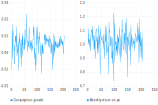

In [12]:
gadfly()
using Plots
c = Plots.plot(y=ΔC, lab = "Consumption growth", legend = :bottom);
r = Plots.plot(y=R, lab = "Monthly return on ssi", legend = :bottom);
Plots.subplot(c, r)

In [13]:
function g(θ)
    β = θ[1]
    γ = θ[2]
    exp(log(β) + (γ-1)*ΔC + log(R))-1
end


function h(θ)
    m = Z.*g(θ)
    ex = maximum(mapslices(x -> sum(isnan(x)), Z, 1))
    m[ex+1:end,:]
end

h (generic function with 1 method)

In [14]:
g([.96, .5])   ## (T × 1)  

204-element Array{Float64,1}:
  0.00493269
 -0.0455964 
  0.0686378 
 -0.0254862 
 -0.0136114 
 -0.03097   
 -0.0647865 
  0.0387012 
 -0.0593637 
 -0.079341  
 -0.0567475 
  0.0269841 
  0.0610079 
  ⋮         
 -0.0349629 
  0.0238539 
 -0.130151  
  0.0446906 
 -0.041434  
 -0.0549339 
 -0.0096596 
 -0.0581905 
 -0.133314  
  0.00862127
 -0.159067  
  0.038253  

In [15]:
## Select the instruments
Z = [ones(size(ΔC)) [NaN; ΔC[1:end-1]]] 

204x2 Array{Float64,2}:
 1.0  NaN         
 1.0   -0.00970405
 1.0    0.0135159 
 1.0    0.00418465
 1.0   -0.00335009
 1.0    0.0172782 
 1.0    0.0114536 
 1.0    0.0101319 
 1.0    0.00573239
 1.0    0.00513185
 1.0   -0.00682834
 1.0   -0.00585512
 1.0    0.00474956
 ⋮                
 1.0    0.00882475
 1.0    0.00801492
 1.0    0.00565139
 1.0    0.00810953
 1.0    0.00549766
 1.0    0.00718213
 1.0    0.00435467
 1.0    0.00675655
 1.0    0.00181141
 1.0   -0.00057154
 1.0    0.00066272
 1.0    0.00557075

In [16]:
h([.996, .5])   ## T × m --> Actual moment conditions to use

203x2 Array{Float64,2}:
 -0.00980624   9.51602e-5 
  0.108712     0.00146934 
  0.0110581    4.62741e-5 
  0.0233781   -7.83189e-5 
  0.00536862   9.27599e-5 
 -0.029716    -0.000340355
  0.0776525    0.000786764
 -0.0240899   -0.000138093
 -0.0448162   -0.00022999 
 -0.0213756    0.00014596 
  0.065496    -0.000383487
  0.100796     0.000478735
  0.0787464    9.10914e-5 
  ⋮                       
  0.00122599   1.08191e-5 
  0.0622484    0.000498916
 -0.0975316   -0.000551189
  0.0838665    0.000680118
 -0.00548778  -3.017e-5   
 -0.0194939   -0.000140008
  0.0274782    0.000119658
 -0.0228726   -0.00015454 
 -0.100813    -0.000182614
  0.0464446   -2.65449e-5 
 -0.127532    -8.45179e-5 
  0.0771875    0.000429992

In [18]:
function J(θ)
    ht = h(θ);
    hT = sum(ht, 1)
    out = (hT*W*hT')
    out[1]
end

J (generic function with 1 method)

In [20]:
W = eye(2);
J([.96, .5])

19.05474312301578

In [21]:
## Minimization
optimize(J, [.96, .9])  ## γ < 1 !!!

LoadError: LoadError: DomainError:
while loading In[21], in expression starting on line 2

In the optimization problem that defines the GMM estimator
$$
\hat{\theta}^{gmm}=\arg\min_{\theta\in\Theta}\left(\frac{1}{T}\sum_{t=1}^{T}h(w_{t},\theta)\right)'\mathbf{W}\left(\frac{1}{T}\sum_{t=1}^{T}h(w_{t},\theta)\right),
$$

\Theta is a compact set. This is atechnical assumption and it can be relaxed by adding additional requirement on $h$ and the stochastic process $w_t$. 

Here the problem is that the function $g(w_t,\theta)$ is not defined for $\gamma>1$. Thus we have to minimize the GMM objective function under the following constraint. 
$$
\gamma <1
$$

Additionally, we will constraint $\beta \in [0,1]$. 

To carry out a constrained optimization, we could use a constrained routines. However, solving constrained optimization problems is substantially harder than solving unconstrained optimization problems. In this case, it is possible to  convert the constrained optimization problem into an unconstrained optimization problem by transforming the variables. 


In [23]:
function J(θ)
    β = 1/(1+exp(-θ[1]))
    γ = -exp(θ[2]) + 1    
    ht = h([β, γ]);    
    hT = sum(ht, 1)
    out = (hT*W*hT')
    out[1]
end

J (generic function with 1 method)

When the GMM objective function is defined as above, we are minimizing `J(θ)` with respect to unconstrained $\theta$ which are related to our parameters of interest by these transformation:

$$
\theta[1] = \log \left(\frac{\beta}{1-\beta}\right)
$$
and 
$$
\theta[2] = log(1-\gamma).
$$


In [24]:
Jmin = optimize(J, [log(0.96/(1-0.96)), log(1-0.5)])

Results of Optimization Algorithm
 * Algorithm: Nelder-Mead
 * Starting Point: [3.178053830347945,-0.6931471805599453]
 * Minimizer: [5.315166322116017,1.1586200301916147]
 * Minimum: 0.000082
 * Iterations: 440
 * Convergence: true
   * |x - x'| < NaN: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-08: true
   * |g(x)| < NaN: false
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 824
 * Gradient Calls: 0

In [25]:
θs = Jmin.minimum;
β = 1/(1+exp(-θs[1]));
γ = -exp(θs[2])+1;
[β, γ]

2-element Array{Float64,1}:
  0.995108
 -2.18553 

Let's now use more instruments to improve efficiency. The only think we have to do is to augment the `Z` with variables that are known at time $t$. We include up to 4 lags of consumption growth. 

In [26]:
#Z = [ones(size(ΔC)) [NaN; ΔC[1:end-1]] [NaN; NaN; ΔC[1:end-2]] [NaN; NaN; NaN; ΔC[1:end-3]] [NaN; NaN; NaN; NaN; ΔC[1:end-4]]]
Z = [ones(size(ΔC)) [NaN; ΔC[1:end-1]] [NaN; NaN; ΔC[1:end-2]] ]

204x3 Array{Float64,2}:
 1.0  NaN           NaN         
 1.0   -0.00970405  NaN         
 1.0    0.0135159    -0.00970405
 1.0    0.00418465    0.0135159 
 1.0   -0.00335009    0.00418465
 1.0    0.0172782    -0.00335009
 1.0    0.0114536     0.0172782 
 1.0    0.0101319     0.0114536 
 1.0    0.00573239    0.0101319 
 1.0    0.00513185    0.00573239
 1.0   -0.00682834    0.00513185
 1.0   -0.00585512   -0.00682834
 1.0    0.00474956   -0.00585512
 ⋮                              
 1.0    0.00882475    0.00453256
 1.0    0.00801492    0.00882475
 1.0    0.00565139    0.00801492
 1.0    0.00810953    0.00565139
 1.0    0.00549766    0.00810953
 1.0    0.00718213    0.00549766
 1.0    0.00435467    0.00718213
 1.0    0.00675655    0.00435467
 1.0    0.00181141    0.00675655
 1.0   -0.00057154    0.00181141
 1.0    0.00066272   -0.00057154
 1.0    0.00557075    0.00066272

In [27]:
W = eye(3)
Jmin = optimize(J, [log(0.96/(1-0.96)), log(2-1)])  ## γ < 1 !!!

Results of Optimization Algorithm
 * Algorithm: Nelder-Mead
 * Starting Point: [3.178053830347945,0.0]
 * Minimizer: [5.323543984587871,1.1746527376166733]
 * Minimum: 0.000248
 * Iterations: 515
 * Convergence: true
   * |x - x'| < NaN: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-08: true
   * |g(x)| < NaN: false
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 957
 * Gradient Calls: 0

In [28]:
θs = Jmin.minimum;
β = 1/(1+exp(-θs[1]));
γ = -exp(θs[2])+1;
[β,γ]

2-element Array{Float64,1}:
  0.995148
 -2.23702 

In [31]:
ht = h([β,γ])
W = inv(ht'ht)

3x3 Array{Float64,2}:
    1.84185    -135.435     -77.9914
 -135.435     40957.3    -11453.3   
  -77.9914   -11453.3     31476.2   

In [32]:
Jmin = optimize(J, θs)

Results of Optimization Algorithm
 * Algorithm: Nelder-Mead
 * Starting Point: [5.323543984587871,1.1746527376166733]
 * Minimizer: [25.804178410848113,1.459822788888433]
 * Minimum: 10.255502
 * Iterations: 48
 * Convergence: true
   * |x - x'| < NaN: false
   * |f(x) - f(x')| / |f(x)| < 1.0e-08: true
   * |g(x)| < NaN: false
   * Reached Maximum Number of Iterations: false
 * Objective Function Calls: 90
 * Gradient Calls: 0

In [33]:
θs = Jmin.minimum;
β = 1/(1+exp(-θs[1]));
γ = -exp(θs[2])+1;
[β, γ]

2-element Array{Float64,1}:
  1.0   
 -3.3052

## Pricing the risk free bond
According to the pricing kernel
$$
1+r^f_t = \frac{1}{E[\beta (C_t/C_{t+1})^{\gamma-1}]}
$$
where $r^f_t$ is the return on a risk free asset. 



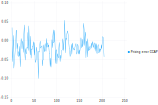

In [35]:
Plots.plot(y=Rf-1./exp(log(β) + (γ-1)*ΔC), lab = "Pricing error CCAPM")


## Overidentification
The objective function can be used for testing the following null hypothesis
$$
H_0: E[h(w_t,\theta_0)] = 0  
$$
against the generic alternative
$$
H_1:\left\Vert  E[h(w_t,\theta_0)]\right\Vert \neq 0.  
$$
In particular, 
$$
J(\hat{\theta}, W^{opt}) \sim \chi^2_{m-k},
$$
where $m$ is the number of moment resctrictions (the dimension of $q$) and $k$ is the dimension of $\theta$. 


In [36]:
Jmin.f_minimum

10.255501557568625

# Using a dedicated package


`MomentBasedEstimators` is a package that handle, among other estimation techniques, GMM. THe package is written with generality in mind and this means that is quite difficult to use. This  is the usual tradeoff between power and usability. What you get back is more precise estimates, nice output and additional features. 

## Exactly identified model

We start by the exactly identified case as above. 

In [ ]:
Z = [ones(size(ΔC)) [NaN; ΔC[1:end-1]]]

The initial thing to do is to instantiate the estimator

step_1 = GMMEstimator(h, [.9, 0.], initialW = eye(2), mgr = OneStepGMM())

`step_1` is a type `GMMEstimator` which contains the information to do the estimation. In particular, the first argument `h` passes the moment function, the second `[0.9, 0]` are the initial values, the third is passed through a keyword `initialW` is the initial weighting matrix. The third argument `mgr` is a little bit more complicated, but it basically tell whether to use a `OneStepGMM` or a `TwoStepGMM()`.

In [ ]:
setparLB!(step_1, [0, -Inf]);
setparUB!(step_1, [1, 1]);

In [ ]:
With these two commands we set the parameter lower and upper bounds. Finally we estimate the model. 

In [ ]:
estimate!(step_1)

Notice that the `J-test` does not make sense here (P-value = NaN), because the model is exactly identified. 

To obtain the second stage we can do the following

In [ ]:
Ω = mfvcov(step_1)   ## This calculate an estimate of Ω = E[h(w, \theta_0)h(w_tm \theta_0)']
W = pinv(Ω)
step_2 = GMMEstimator(h, coef(step_1), initialW = W, mgr = OneStepGMM())
setparLB!(step_1, [0, -Inf]);
setparUB!(step_1, [1, 1]);
estimate!(step_2)

Alternatively, you can directly get the efficient two-step GMM with 

In [ ]:
OptGMM = GMMEstimator(h, coef(step_1), initialW = W, mgr = TwoStepGMM())
setparLB!(OptGMM, [0, -Inf]);
setparUB!(OptGMM, [1, 1]);
estimate!(OptGMM)